## Выявление картинок, которые не содержат рукописные цифры, с помощью автокодировщика.

Импортируем библиотеки и данные

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import datasets, layers, models, losses

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

mnist = tf.keras.datasets.mnist

(digits_train, digits_train_labels), (digits_test, digits_test_labels) = tf.keras.datasets.mnist.load_data()
digits_train_norm, digits_test_norm = digits_train / 255.0, digits_test / 255.0

(fashion_train, _), (fashion_test, _) = fashion_mnist.load_data()
fashion_train_norm, fashion_test_norm = fashion_train / 255.0, fashion_test / 255.0

Используем [туториал](https://www.tensorflow.org/tutorials/generative/autoencoder). Создадим класс автокодировщика.

In [13]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim) 

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(digits_train_norm, digits_train_norm, 
          epochs=20, 
          batch_size=512,
          validation_data=(digits_test_norm, digits_test_norm),
          shuffle=True)

Epoch 1/20
118/118 [==============================] - 2s 14ms/step - loss: 0.0816 - val_loss: 0.0454
Epoch 2/20
118/118 [==============================] - 2s 13ms/step - loss: 0.0373 - val_loss: 0.0307
Epoch 3/20
118/118 [==============================] - 2s 13ms/step - loss: 0.0274 - val_loss: 0.0237
Epoch 4/20
118/118 [==============================] - 2s 13ms/step - loss: 0.0218 - val_loss: 0.0192
Epoch 5/20
118/118 [==============================] - 2s 13ms/step - loss: 0.0180 - val_loss: 0.0161
Epoch 6/20
118/118 [==============================] - 2s 13ms/step - loss: 0.0153 - val_loss: 0.0137
Epoch 7/20
118/118 [==============================] - 1s 13ms/step - loss: 0.0131 - val_loss: 0.0119
Epoch 8/20
118/118 [==============================] - 1s 13ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 9/20
118/118 [==============================] - 2s 13ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 10/20
118/118 [==============================] - 2s 13ms/step - loss: 0.0091 - val_lo

Проверим работу автокодировщика

In [15]:
encoded_imgs = autoencoder.encoder(digits_test_norm).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

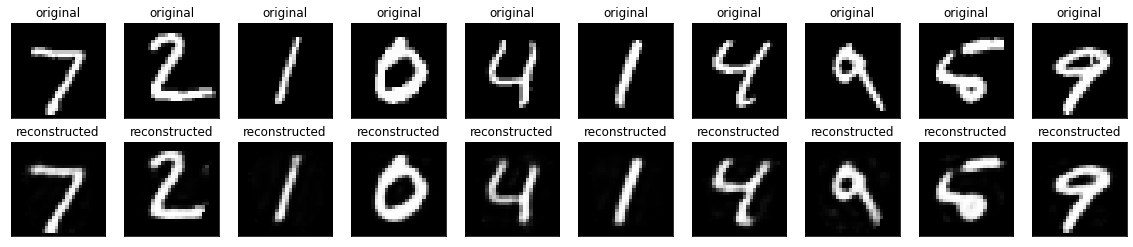

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(digits_test_norm[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Определим критерий (пороговое значение threshold), по которому будем определять, является ли изображение цифрой.

In [17]:
reconstructions = autoencoder.predict(digits_train_norm)
train_loss = tf.keras.losses.mae(reconstructions, digits_train_norm)

a=0
for i in range(len(train_loss)):
  a+=np.mean(train_loss[i]) + np.std(train_loss[i])
print(a/len(train_loss))

threshold = np.mean(train_loss) + 3*np.std(train_loss)
print("Threshold: ", threshold)

0.04455385274675941
Threshold:  0.0925697939532605


Проверим использование этого критерия на выборке из 1000 изображений-аномалий, например на изображениях одежды

In [18]:
print("Количество аномалий: {}".format(len(fashion_train_norm[0:1000])))

detected_count = 0

for s in fashion_train_norm[0:1000]:
  pred = autoencoder.predict(np.array([s]))[0]
  loss = tf.keras.losses.mae(pred, s)

  th = float(np.mean(loss) + np.std(loss))

  if th > threshold:
    detected_count += 1

print("Выявленные аномалии: {}".format(detected_count))

Количество аномалий: 1000
Выявленные аномалии: 994


Проверим использование этого критерия на выборке из 1000 нормальных изображений, например на изображениях цифр

In [24]:
print("Количество цифр: {}".format(len(digits_test_norm[0:1000])))

detected_count = 0

for s in digits_test_norm[0:1000]:
  pred = autoencoder.predict(np.array([s]))[0]
  loss = tf.keras.losses.mae(pred, s)

  th = float(np.mean(loss) + np.std(loss))

  if th < threshold:
    detected_count += 1


print("Выявленные цифры: {}".format(detected_count))

Количество цифр: 1000
Выявленные цифры: 1000
